In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
torch.__version__

'1.2.0'

In [2]:
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("data/snli_train.tsv",sep="\t")
df_v = pd.read_csv("data/snli_val.tsv",sep="\t")

In [5]:
df_v.describe()

sentence1  \
count                                                1000   
unique                                                891   
top     A man and woman are sitting at a restaurant ta...   
freq                                                    2   

                   sentence2    label  
count                   1000     1000  
unique                   999        3  
top     People are outside .  neutral  
freq                       2      338

In [6]:
df_v.head()

sentence1  \
0  Three women on a stage , one wearing red shoes...   
1  Four people sit on a subway two read books , o...   
2  bicycles stationed while a group of people soc...   
3                  Man in overalls with two horses .   
4  Man observes a wavelength given off by an elec...   

                                           sentence2          label  
0          There are two women standing on the stage  contradiction  
1  Multiple people are on a subway together , wit...     entailment  
2     People get together near a stand of bicycles .     entailment  
3                  a man in overalls with two horses     entailment  
4  The man is examining what wavelength is given ...     entailment

In [7]:
first = df["sentence1"].values#[0:5000]
second = df["sentence2"].values#[0:5000]
labels = df["label"].values#[0:5000]

first_v = df_v["sentence1"].values#[0:500]
second_v = df_v["sentence2"].values#[0:500]
labels_v = df_v["label"].values#[0:500]

In [8]:
print(first[-1],second[-1],labels[-1])

Two gentlemen in tuxes play the keyboard and guitar . The two guys are in a band . neutral


In [9]:
print(len(set(labels)))

3


In [10]:
import string
punctuations = string.punctuation

In [11]:
labels[:10]

array(['neutral', 'entailment', 'neutral', 'contradiction',
       'contradiction', 'entailment', 'contradiction', 'neutral',
       'entailment', 'entailment'], dtype=object)

In [12]:
label_to_idx = {
    'entailment':0,
    'contradiction':1,
    'neutral':2
}

for i in range(len(labels)):
    labels[i] = label_to_idx[labels[i]]
    
for i in range(len(labels_v)):
    labels_v[i] = label_to_idx[labels_v[i]]

In [13]:
labels = labels.astype("int32")
labels_v = labels_v.astype("int32")

In [14]:
def tokenize(sent):
  #tokens = tokenizer(sent)
  return [word.lower() for word in sent.split(" ") if (word not in punctuations)]

In [15]:
tokenize("helldoifjsdoihfs . numpy")

['helldoifjsdoihfs', 'numpy']

In [16]:
labels

array([2, 0, 2, ..., 2, 1, 2], dtype=int32)

In [17]:
def tokenize_dataset(dataset1,dataset2):
    token_dataset1 = []
    token_dataset2 = []
    all_tokens = []
    
    for sample in dataset1:
        tokens = tokenize(sample)
        token_dataset1.append(tokens)
        all_tokens += tokens
        
    for sample in dataset2:
        tokens = tokenize(sample)
        token_dataset2.append(tokens)
        all_tokens += tokens

    return token_dataset1,token_dataset2, all_tokens


In [18]:
torch.LongTensor(labels);
torch.LongTensor(labels_v);

In [19]:
sent1_tokens,sent2_tokens,all_train_tokens = tokenize_dataset(first,second)
sent1_tokens_v,sent2_tokens_v,all_train_tokens_v = tokenize_dataset(first_v,second_v)

In [20]:
import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

data = load_vectors("data/wiki-news-300d-1M.vec")

In [21]:
from collections import Counter

max_vocab_size = 20000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)
token2id_v, id2token_v = build_vocab(all_train_tokens_v)

In [22]:
new_data = {}
emb_dim = 300
new_data["<pad>"] = np.zeros((emb_dim,))
new_data["<unk>"] = np.random.normal(scale=0.6, size=(emb_dim, ))
for i in range(2,len(id2token)):
    word = id2token[i]
    try:
        new_data[word] = np.fromiter(data[word],np.float64)
    except KeyError:
        new_data[word] = new_data["<unk>"]
        
    #if i > 00000:
     #   break
len(new_data)

20002

In [23]:
new_data


{'<pad>': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

In [24]:
print(sent2_tokens[10])
print(all_train_tokens[0:10])
print(len(set(all_train_tokens)))

['the', 'dog', 'is', 'jumping', 'high']
['a', 'young', 'girl', 'in', 'a', 'pink', 'shirt', 'sitting', 'on', 'a']
21006


In [25]:
len(id2token_v)

2539

In [26]:
import random
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 2544 ; token tags
Token tags; token id 2544


In [27]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

sent1_indices = token2index_dataset(sent1_tokens)
sent2_indices = token2index_dataset(sent2_tokens)
sent1_indices_v = token2index_dataset(sent1_tokens_v)
sent2_indices_v = token2index_dataset(sent2_tokens_v)
#test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("sent1 dataset size is {}".format(len(sent1_indices)))
print ("sent2 dataset size is {}".format(len(sent2_indices)))
print ("Val dataset size is {}".format(len(sent1_indices_v)))
#print ("Test dataset size is {}".format(len(test_data_indices)))

sent1 dataset size is 100000
sent2 dataset size is 100000
Val dataset size is 1000


In [28]:
import random
rand_training_example = random.randint(0, len(first) - 1)
print (sent1_indices[rand_training_example])
print(sent1_tokens[rand_training_example])
print (sent2_indices[rand_training_example])
print(sent2_tokens[rand_training_example])
print(labels[rand_training_example])

[2, 41, 5, 44, 2, 120, 27, 2, 698, 341, 2, 357]
['a', 'person', 'is', 'holding', 'a', 'camera', 'while', 'a', 'skier', 'does', 'a', 'trick']
[2, 4110, 5, 166, 47, 2466]
['a', 'whale', 'is', 'swimming', 'by', 'itself']
1


In [29]:
max(max([len(s) for s in sent1_tokens]),max([len(s) for s in sent2_tokens]))

78

In [30]:
def build_word_embedding(id2token,new_data,emd_dim=300):
    matrix_len = len(id2token)
    weights_matrix = np.zeros((matrix_len, emb_dim))
    words_found = 0

    for i, token in enumerate(id2token):
        weights_matrix[i] = new_data[token]
        words_found += 1
    return weights_matrix,words_found

In [82]:
weights_matrix,words_found = build_word_embedding(id2token,new_data)

In [86]:
weights_matrix = torch.from_numpy(weights_matrix).float()

In [87]:
weights_matrix.requires_grad

False

In [92]:
weights_matrix2 = torch.cat((weights_matrix[0],weights_matrix[2:]),dim=-1)
weights_matrix2.shape

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 1 and 2 at /Users/distiller/project/conda/conda-bld/pytorch_1565272679438/work/aten/src/TH/generic/THTensor.cpp:680

In [101]:
weights_matrix[0].reshape(1,-1).shape

torch.Size([1, 300])

In [109]:
weights_matrix2 = torch.cat((weights_matrix[0].reshape(1,-1),weights_matrix[2:]))
weights_matrix2[10].requires_grad

False

In [111]:
temp = torch.tensor(weights_matrix[1],requires_grad = True)

/anaconda3/envs/ds1011/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [116]:
a = torch.cat((weights_matrix[0].reshape(1,-1),temp.reshape(1,-1)))

In [118]:
a[0].requires_grad

True

In [32]:
MAX_SENTENCE_LENGTH = 20


In [33]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

sent1_indices = token2index_dataset(sent1_tokens)
sent2_indices = token2index_dataset(sent2_tokens)
sent1_indices_v = token2index_dataset(sent1_tokens_v)
sent2_indices_v = token2index_dataset(sent2_tokens_v)

In [34]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list1,data_list2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.data_list2) == len(self.target_list))

    def __len__(self):
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1,len(token_idx1),token_idx2,len(token_idx2),label]


In [35]:
train_dataset = SNLIDataset(sent1_indices,sent2_indices,labels)
val_dataset = SNLIDataset(sent1_indices_v,sent2_indices_v,labels_v)

In [36]:
#print(train_dataset[0])
s = val_dataset[99][0]
t = val_dataset[99][2]
#print(s)
print([id2token[i] for i in s])
print([id2token[i] for i in t])
print(val_dataset[99][-1])
#print([id2token[i] for i in range(len(train_dataset[0])])

['the', 'boy', 'wearing', 'the', 'blue', 'hooded', 'top', 'is', 'holding', 'a', 'baby', 'goat', 'in', 'his', 'arms']
['a', 'boy', 'ran', 'from', 'a', 'goat']
1


In [37]:
print("x {}{};\ny {}".format(train_dataset[99][0], train_dataset[99][2],train_dataset[99][-1]))

x [2, 22, 688, 184, 78, 2, 512, 10, 2329][80, 688, 204, 1516];
y 0


In [38]:
def SNLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[-1])
        length_list1.append(datum[1])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
    for datum in batch:
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
    return [torch.from_numpy(np.array(data_list1)), torch.LongTensor(length_list1),torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list2), torch.LongTensor(label_list)]

In [39]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [40]:
for i, (data1, lengths1,data2, lengths2, labels) in enumerate(val_loader):
    print(data1.shape)
    #print(lengths1[1].item())
    ##print(data2[1])
    #print(lengths2[1].item())
    #print(labels[1].item())
    break

torch.Size([32, 20])


In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, weight_matrix):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
#         self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.embed = nn.Embedding.from_pretrained(weight_matrix,freeze=True)
        #self.concat = 
        self.linear1 = nn.Linear(emb_dim,64)
        self.linear2 = nn.Linear(64,32)
        self.linear3 = nn.Linear(emb_dim,3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,data1,length1,data2,length2):
        
        prem_embed = self.embed(data1) # 64xlen
        prem_embed = torch.sum(prem_embed, dim=1) #64
        prem_embed /= length1.view(length1.size()[0],1).expand_as(prem_embed).float()
        hypo_embed = self.embed(data2)
        hypo_embed = torch.sum(hypo_embed, dim=1)
        hypo_embed /= length2.view(length2.size()[0],1).expand_as(hypo_embed).float()
        
        out = prem_embed * hypo_embed
        #out = self.linear1(out)
        #out = self.relu(out)
        #out = self.dropout(out)
        #out = self.linear2(out)
        #out = self.relu(out)
        #out = self.dropout(out)
        out = self.linear3(out.float())
        
        return out

In [49]:
weights_matrix = torch.from_numpy(weights_matrix).float()

TypeError: expected np.ndarray (got Tensor)

In [81]:
weights_matrix

tensor([[ 0.3284, -0.2632,  0.1074,  ..., -0.0114, -0.0877, -0.2559],
        [ 0.3389, -1.6808,  0.1350,  ..., -0.1674, -2.8432,  0.5509],
        [ 0.2817, -0.2726, -0.6568,  ..., -0.1013,  0.9323,  0.0532],
        ...,
        [ 0.1462,  0.1360, -0.0151,  ...,  0.1454, -0.0461, -0.1294],
        [-0.2261, -0.3015, -0.4145,  ..., -0.0489, -0.2517, -0.2641],
        [-0.4153, -0.5529,  0.4321,  ..., -0.3206, -0.3364,  0.7479]],
       grad_fn=<CopySlices>)

In [77]:
temp.requires_grad = True
weights_matrix[1] = temp

In [79]:
weights_matrix[0].requires_grad

True

In [65]:
# emb_dim = 128
# model = BagOfWords(len(id2token), emb_dim)

model = BagOfWords(weights_matrix)

In [66]:
model.embed.weight.shape

torch.Size([20002, 300])

In [67]:
criterion = torch.nn.CrossEntropyLoss()  

learning_rate = 0.01
weight_decay = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0)

In [68]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

22247


In [69]:
num_epochs = 5 # number epoch to train
val_acc_graph = []
train_loss_graph = []
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    sample = []
    for data1, length1, data2, length2, labels in loader:
        data_batch1, length_batch1, data_batch2, length_batch2, label_batch = data1, length1, data2, length2, labels
        outputs = F.softmax(model(data_batch1, length_batch1,data_batch2,length_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        temp = predicted
        sample.append([temp,labels])
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total), sample

for epoch in range(num_epochs):
    for i, (data1, length1, data2, length2, labels) in enumerate(train_loader):
        model.train()
        data_batch1, length_batch1,data_batch2, length_batch2, label_batch = data1, length1, data2, length2, labels
        optimizer.zero_grad()
        outputs = model(data_batch1, length_batch1,data_batch2,length_batch2)
        loss = criterion(outputs, label_batch)
        #print(loss)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 50 == 0:
            #pass
            # validate
            val_acc = test_model(val_loader, model)[0]
            val_acc_graph.append(val_acc)
            train_loss_graph.append(loss.item())
            print(loss.item())
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
               epoch+1, num_epochs, i+1, len(train_loader), val_acc))


0.8763570189476013
Epoch: [1/5], Step: [51/3125], Validation Acc: 58.7
1.073128581047058
Epoch: [1/5], Step: [101/3125], Validation Acc: 58.5
0.7126289010047913
Epoch: [1/5], Step: [151/3125], Validation Acc: 57.9
0.6839670538902283
Epoch: [1/5], Step: [201/3125], Validation Acc: 59.8
0.9349623918533325
Epoch: [1/5], Step: [251/3125], Validation Acc: 59.6
0.7649198770523071
Epoch: [1/5], Step: [301/3125], Validation Acc: 59.0
0.7259975075721741
Epoch: [1/5], Step: [351/3125], Validation Acc: 59.6
0.9813333749771118
Epoch: [1/5], Step: [401/3125], Validation Acc: 60.7
0.6075894832611084
Epoch: [1/5], Step: [451/3125], Validation Acc: 58.8
1.0522382259368896
Epoch: [1/5], Step: [501/3125], Validation Acc: 59.8
0.9931111931800842
Epoch: [1/5], Step: [551/3125], Validation Acc: 58.5
0.9257145524024963
Epoch: [1/5], Step: [601/3125], Validation Acc: 59.2
0.7510531544685364
Epoch: [1/5], Step: [651/3125], Validation Acc: 59.3
0.8281879425048828
Epoch: [1/5], Step: [701/3125], Validation Acc:

1.011690616607666
Epoch: [2/5], Step: [2601/3125], Validation Acc: 61.0
0.8283344507217407
Epoch: [2/5], Step: [2651/3125], Validation Acc: 60.2
1.0318081378936768
Epoch: [2/5], Step: [2701/3125], Validation Acc: 60.3
0.7488659620285034
Epoch: [2/5], Step: [2751/3125], Validation Acc: 60.6
0.8266199231147766
Epoch: [2/5], Step: [2801/3125], Validation Acc: 58.0
0.8219900131225586
Epoch: [2/5], Step: [2851/3125], Validation Acc: 60.3
0.7349817752838135
Epoch: [2/5], Step: [2901/3125], Validation Acc: 60.0
0.9040660858154297
Epoch: [2/5], Step: [2951/3125], Validation Acc: 59.3
0.9477314949035645
Epoch: [2/5], Step: [3001/3125], Validation Acc: 60.0
0.6741714477539062
Epoch: [2/5], Step: [3051/3125], Validation Acc: 60.7
1.0368722677230835
Epoch: [2/5], Step: [3101/3125], Validation Acc: 60.3
1.0452897548675537
Epoch: [3/5], Step: [51/3125], Validation Acc: 58.8
0.7338764667510986
Epoch: [3/5], Step: [101/3125], Validation Acc: 58.4
0.8149604797363281
Epoch: [3/5], Step: [151/3125], Vali

0.7622509002685547
Epoch: [4/5], Step: [2101/3125], Validation Acc: 59.7
0.7938160300254822
Epoch: [4/5], Step: [2151/3125], Validation Acc: 59.3
0.7498000860214233
Epoch: [4/5], Step: [2201/3125], Validation Acc: 61.5
0.6643949747085571
Epoch: [4/5], Step: [2251/3125], Validation Acc: 59.8
0.8162952661514282
Epoch: [4/5], Step: [2301/3125], Validation Acc: 59.4
0.7006368637084961
Epoch: [4/5], Step: [2351/3125], Validation Acc: 61.5
0.6313614845275879
Epoch: [4/5], Step: [2401/3125], Validation Acc: 60.4
1.1159090995788574
Epoch: [4/5], Step: [2451/3125], Validation Acc: 58.2
0.6445410251617432
Epoch: [4/5], Step: [2501/3125], Validation Acc: 58.9
0.7981341481208801
Epoch: [4/5], Step: [2551/3125], Validation Acc: 61.3
0.937978982925415
Epoch: [4/5], Step: [2601/3125], Validation Acc: 60.1
0.837409257888794
Epoch: [4/5], Step: [2651/3125], Validation Acc: 61.0
0.7163189649581909
Epoch: [4/5], Step: [2701/3125], Validation Acc: 60.7
0.8093863129615784
Epoch: [4/5], Step: [2751/3125], V

In [70]:
print ("After training for {} epochs".format(num_epochs))
print ("Train Acc {}".format(test_model(train_loader, model)[0]))
print ("Val Acc {}".format(test_model(val_loader, model)[0]))
print("Number of parameters {}".format(count_parameters(model)))

After training for 5 epochs
Train Acc 63.954
Val Acc 57.9
Number of parameters 22247


Text(0.5, 1.0, 'Training loss: DNN, elem-mul, 10000 words, 128d')

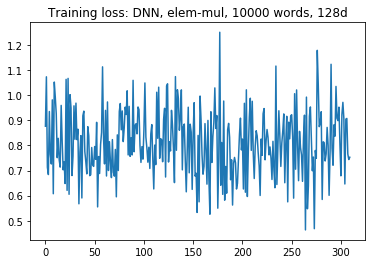

In [71]:
import matplotlib.pyplot as plt
x = np.arange(len(train_loss_graph))
plt.plot(x, train_loss_graph)
plt.title("Training loss: DNN, elem-mul, 10000 words, 128d")

In [72]:
x = np.arange(len(val_acc_graph))
plt.plot(x, val_acc_graph)
plt.title("Validation accuracy: DNN, ele-mul, 10000 words, 128d")

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:
def saveList(myList,filename):
    # the filename should mention the extension 'npy'
    np.save(filename,myList)
    print("Saved successfully!")
train_loss_graph = np.asarray(train_loss_graph, dtype=np.float32)
val_acc_graph = np.asarray(val_acc_graph, dtype=np.float32)
saveList(train_loss_graph,"figures/DNN_train_elemmul_10000_128.npy")
saveList(val_acc_graph,"figures/DNN_val_elemmul_10000_128.npy")

In [ ]:
torch.save(model.state_dict(), "DNN_elemut_SNLI_10000_128.pt")